# Phase 2 - Transfer Learning on CIFAR10

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import time
import os
import copy
from torchvision import utils
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

## 1) Download and Load CIFAR10

You can find CIFAR10 in ```torchvision.datasets.CIFAR10()``` or see [here](https://pytorch.org/vision/0.15/generated/torchvision.datasets.CIFAR10.html#torchvision.datasets.CIFAR10). Please Download the dataset and use Dataloaders to load it.

In [ ]:
transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

batch_size = 64

train_set = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_set = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


## 2) Load Pretrained Model (ResNet18) and Modify Layers
Load ResNet18 model from ```torchvision.models.resnet18()```, make sure to load pretrained model with weights.
You will need to modify the final layer. ResNet outputs 100 lables - please change to the correct output dimension.

In [ ]:
# Instantiate Pretrained ResNet18
resnet18 = models.resnet18(weights='ResNet18_Weights.IMAGENET1K_V1')

# Modify final layer
num_classes = 10
resnet18.fc = nn.Linear(resnet18.fc.in_features, num_classes)

# Load onto GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
resnet18.to(device)

# View Model to validate
print(resnet18)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## 3) Train and Test Functions
You can refer to Phase_1.ipynb to complete these functions. In ```train()```, rather than saving the accuracy and loss per iteration, you will need to save the loss and accuracy ***per epoch***

In [ ]:
# Train Function
def train(model, loss_fn, optimizer, train_loader, valid_loader, batch_size, num_epochs, device):
    if device is not None:
        model.to(device)
    else:
        device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        model.to(device)

    train_losses = []
    train_accuracies = []
    valid_losses = []  # Track validation loss
    valid_accuracies = []  # Track validation accuracy

    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        start_time = time.time()

        # Training phase
        model.train()
        for i, data in enumerate(train_loader, 0):
            images, labels = data[0].to(device), data[1].to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader)
        epoch_accuracy = 100 * correct / total

        # Validation phase
        model.eval()
        valid_running_loss = 0.0
        valid_correct = 0
        valid_total = 0
        for i, data in enumerate(valid_loader, 0):
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            valid_running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            valid_total += labels.size(0)
            valid_correct += (predicted == labels).sum().item()

        valid_epoch_loss = valid_running_loss / len(valid_loader)
        valid_epoch_accuracy = 100 * valid_correct / valid_total

        end_time = time.time()
        elapsed_time = end_time - start_time

        # Print statistics
        print('Epoch [%d/%d], Train Loss: %.4f, Train Accuracy: %.4f, Valid Loss: %.4f, Valid Accuracy: %.4f, Time: %.2fs'
              % (epoch + 1, num_epochs, epoch_loss, epoch_accuracy, valid_epoch_loss, valid_epoch_accuracy, elapsed_time))

        # Append to the lists
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_accuracy)
        valid_losses.append(valid_epoch_loss)
        valid_accuracies.append(valid_epoch_accuracy)

    return train_losses, train_accuracies, valid_losses, valid_accuracies

# Test Function
def test_accuracy(model, test_loader, input_size, device):
    model.to(device)
    correct = 0
    total = 0
    with torch.no_grad():
        for test_data in test_loader:
            images, labels = test_data[0].cuda(), test_data[1].cuda()
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print('Accuracy: %d %%' % (100 * correct / total))

# Plot Learning Curves
def plot_learning_curve(train_losses, train_accuracies, valid_losses, valid_accuracies):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 5))

    # Plot training loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Training Loss', color='blue')
    plt.plot(epochs, valid_losses, label='Validation Loss', color='red')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Losses')
    plt.legend()

    # Plot training accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Training Accuracy', color='blue')
    plt.plot(epochs, valid_accuracies, label='Validation Accuracy', color='red')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracies')
    plt.legend()

    plt.tight_layout()
    plt.show()

## 4) Complete full training and testing pipeline
Retrain the ResNet18 on CIFAR10 Dataset. You can chose the optimizer and loss function.

Epoch [1/10], Train Loss: 0.9481, Train Accuracy: 66.8800, Valid Loss: 0.7711, Valid Accuracy: 73.6700, Time: 269.21s
Epoch [2/10], Train Loss: 0.6831, Train Accuracy: 76.4760, Valid Loss: 0.6100, Valid Accuracy: 78.7000, Time: 263.02s
Epoch [3/10], Train Loss: 0.6061, Train Accuracy: 79.0200, Valid Loss: 0.6177, Valid Accuracy: 78.5300, Time: 263.30s
Epoch [4/10], Train Loss: 0.5585, Train Accuracy: 80.7580, Valid Loss: 0.5436, Valid Accuracy: 80.9600, Time: 263.78s
Epoch [5/10], Train Loss: 0.5284, Train Accuracy: 81.7080, Valid Loss: 0.5958, Valid Accuracy: 80.5800, Time: 264.75s
Epoch [6/10], Train Loss: 0.5013, Train Accuracy: 82.7320, Valid Loss: 0.5377, Valid Accuracy: 82.0100, Time: 267.15s
Epoch [7/10], Train Loss: 0.4818, Train Accuracy: 83.3840, Valid Loss: 0.5410, Valid Accuracy: 81.5400, Time: 271.20s
Epoch [8/10], Train Loss: 0.4636, Train Accuracy: 83.7360, Valid Loss: 0.5152, Valid Accuracy: 82.0800, Time: 270.54s
Epoch [9/10], Train Loss: 0.4454, Train Accuracy: 84.590

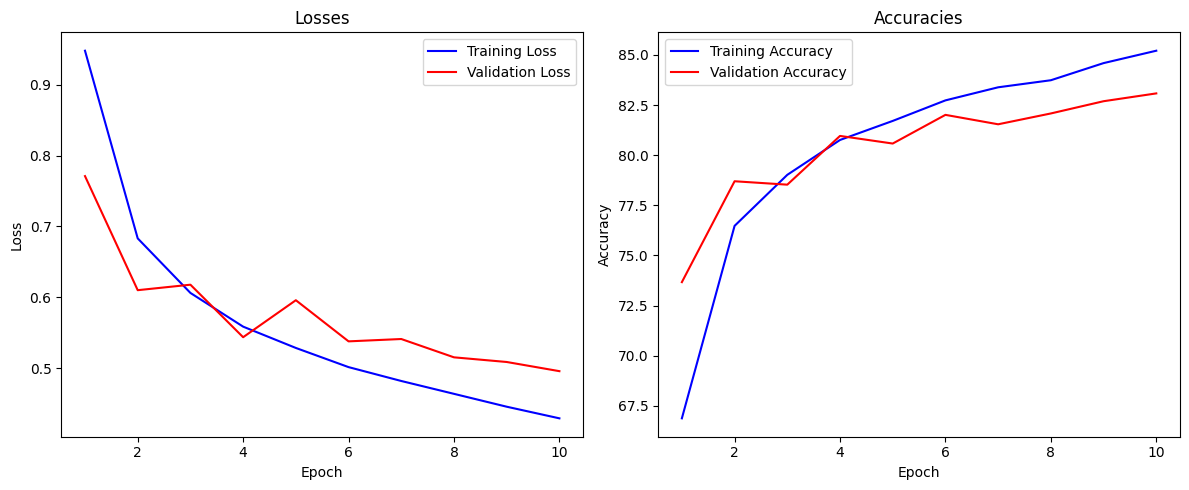

Accuracy: 84 %


In [ ]:
# Define Parameters
num_epochs = 10
lr = 0.01

# Define Loss func and Optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(resnet18.parameters(), lr=0.01, momentum=0.9)

# Train Model
train_losses, train_accuracies, valid_losses, valid_accuracies = train(resnet18, loss_function, optimizer, train_loader, test_loader, 64, 10, device)
plot_learning_curve(train_losses, train_accuracies, valid_losses, valid_accuracies)
test_accuracy(resnet18, test_loader, loss_function, device)

## 5) Confusion Matrix

Write code to plot a confusion matrix after training the above ResNet18. Please make sure the axis have class names (defined in Section 1)

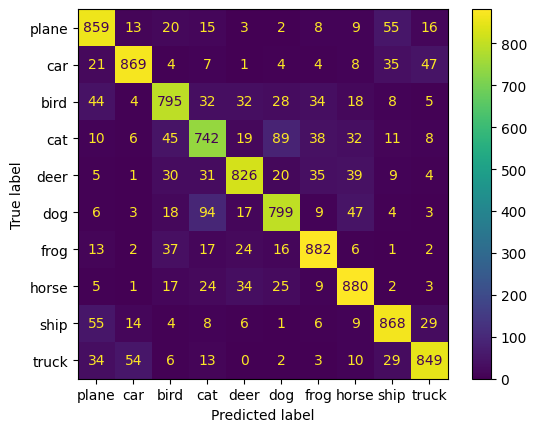

In [ ]:
# YOUR CODE HERE

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# Define a function to plot the confusion matrix
def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    mycmdisp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    mycmdisp.plot()
    plt.show()

resnet18.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = resnet18(images)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

plot_confusion_matrix(y_true, y_pred, classes)

## 6) Freeze Network

### 6.1) Initialize a new ResNEt18, Freeze the model weights except last layer, modify the last layer so we only train the last layer.

In [ ]:
# Instantiate Pretrained ResNet18
resnet18_frz = models.resnet18(weights='ResNet18_Weights.IMAGENET1K_V1')

# Freeze all layers (except last)
for param in resnet18_frz.parameters():
    param.requires_grad = False

# Modify final layer
num_classes = 10
resnet18_frz.fc = nn.Linear(resnet18_frz.fc.in_features, num_classes)

# Load onto GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
resnet18_frz.to(device)

# View Model to validate
print(resnet18_frz)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### 6.2) Retrain the frozen ResNet18 now with the same setup as the previous ResNEt18 (same batch size, optimizer, learning rate, etc.)

Epoch [1/10], Train Loss: 1.2632, Train Accuracy: 56.7640, Valid Loss: 1.1881, Valid Accuracy: 58.0300, Time: 198.24s
Epoch [2/10], Train Loss: 1.2426, Train Accuracy: 57.6080, Valid Loss: 1.3199, Valid Accuracy: 55.8100, Time: 196.83s
Epoch [3/10], Train Loss: 1.2477, Train Accuracy: 57.4900, Valid Loss: 1.1849, Valid Accuracy: 59.1600, Time: 197.27s
Epoch [4/10], Train Loss: 1.2584, Train Accuracy: 57.5340, Valid Loss: 1.1721, Valid Accuracy: 59.5900, Time: 195.10s
Epoch [5/10], Train Loss: 1.2475, Train Accuracy: 57.5800, Valid Loss: 1.1703, Valid Accuracy: 60.1400, Time: 191.48s
Epoch [6/10], Train Loss: 1.2311, Train Accuracy: 58.4340, Valid Loss: 1.1602, Valid Accuracy: 59.7400, Time: 194.72s
Epoch [7/10], Train Loss: 1.2419, Train Accuracy: 57.8320, Valid Loss: 1.2008, Valid Accuracy: 58.4600, Time: 193.43s
Epoch [8/10], Train Loss: 1.2407, Train Accuracy: 58.0100, Valid Loss: 1.2118, Valid Accuracy: 58.4500, Time: 191.74s
Epoch [9/10], Train Loss: 1.2427, Train Accuracy: 58.008

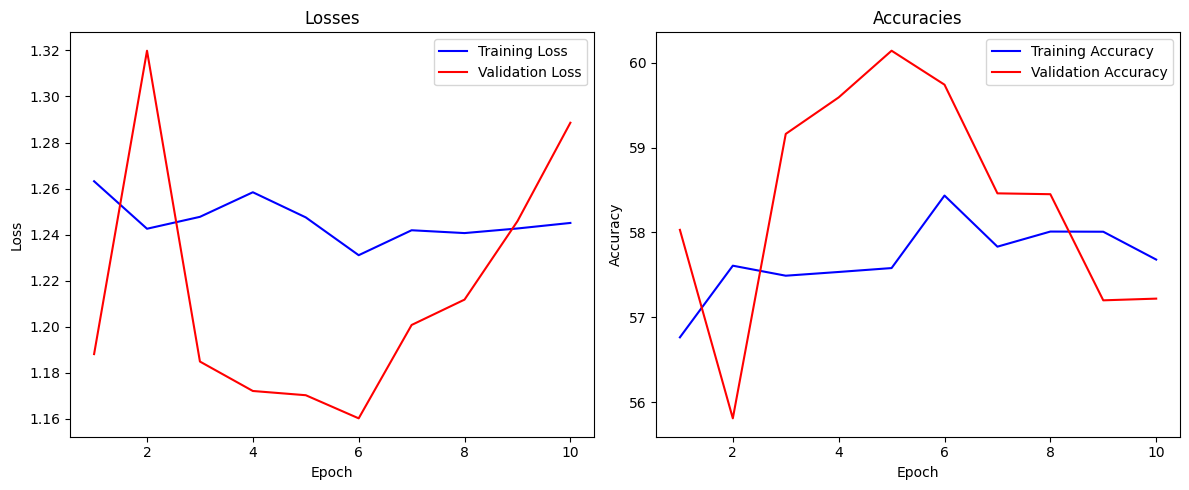

Accuracy: 56 %


In [ ]:
# Define Parameters
num_epochs = 10
lr = 0.01

# Define Loss func and Optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(resnet18_frz.parameters(), lr=0.01, momentum=0.9)

# Train Model
train_losses, train_accuracies, valid_losses, valid_accuracies = train(resnet18_frz, loss_function, optimizer, train_loader, test_loader, 64, 10, device)
plot_learning_curve(train_losses, train_accuracies, valid_losses, valid_accuracies)
test_accuracy(resnet18_frz, test_loader, loss_function, device)

## 6.3) Confusion Matrix (Frozen)

Use the same code as section 5, but now plot the confusion matrix for the results of the frozen network.

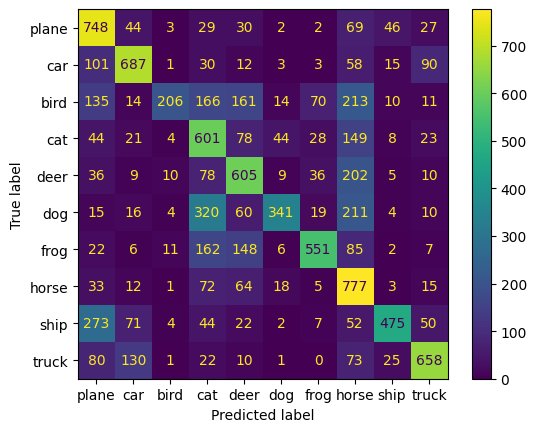

In [ ]:
# YOUR CODE HERE
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# Define a function to plot the confusion matrix
def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    mycmdisp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    mycmdisp.plot()
    plt.show()

resnet18_frz.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = resnet18_frz(images)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

plot_confusion_matrix(y_true, y_pred, classes)

## 7) Reporting

Please answer the following questions based on the training and learning curves from the previous sections.

#### Q 7.1) What is transfer learning and why would it be useful?

#### Q 7.2) What (if any) modifications to the pretrained model would you need to do and why?

#### Q 7.3) Why would you retrain from a pretrained network? What is advantage of not re-initalizing the pre-trained network.

#### Q 7.4) Please explain precision and recall.

#### Q 7.5) Explain what a confusion matrix is. Use your output confusion matrix as an example.

#### Q 7.6) What was the difference between freezing layers and retraining all? Explain in terms of classification metrics and why you saw such metrics and confusuon matrix. Is what you say as expected?

#### Q 7.7) For a pretrained model like ResNet, in what general scenarios would you (1) freeze your pretrained weights and retrain last layer, (2) retrain entire architecture, and (3) Freeze all convolution layer weights and retrain all FC layers? Explain with example scenarios if possible.

7.1) Transfer learning is when we use a pretrained model which already has a set of weights defined and since it is defined we just run it on our dataset to fine tune the weights to make it more accurate for our data. It is important as it reduces training time and gives higher accuracy since the model was trained before we train it with our data.



7.2) We need to change the final layer output size of the pretrained model. We do this as the model is trained on some data and we want to use this on our particular dataset, so we change the final layer output dimensions to match the dataset.

7.3) We retrain a pretrained model so that model is training with our data is able to predict the data we want it to predict accuracy, if this is not done then the output will be similiar to freezing the layer where the model will keep predicting the data it is pretrained on. The advantage of not re-initializig as the weights don't need be trained from scratch which is time consuming, instead the model with adjust it's initial weights which makes it faster.

7.4) Precision measures the accuracy of returning only the data points in a class. Recall measures the accuracy to identify all data points in a relevant class

7.5) A confusion matrix represents the prediction summary in matrix form. It shows how many prediction are correct and incorrect per class. In the confusion matrix used in the notebooks when it value has plane, plane (predicted label, true label) that means it is a plane identified as a plane, when it is a car, plane means that a plane has been predicted as car and the value represented how many times this happened.

7.6) When we freeze a layer in the pretrained model the weight of the layer does not change while we train the model with the new data. To observe the difference we can see the confusion matrix of the model where we retrain all we can see that there are less number of cases where the predicted label is not the same as the true label (the diagonal values are high), compared to the model where layers are froze we see high values apart from the diagonal values (diagonal values represent the number of correctly predicted values)

7.7) We would want to freeze your pretrained weights and retrain last layer, when we want to train the model on a dataset very similiar to the pretrained dataset however there are slight changes and we want to change the output dimensions. We would want to retrain entire architecture when the new dataset is different compared to pretrained dataset like in this lab's Phase 2 where using a pretrained with weights made training faster. Lastly we would want to freeze all convolution layer weights and retrain all FC layers when we feel the filters and data from the convolution layer is good to use for our dataset however the training for detecting these images is different, an example would be when extract featuring from images similiar to ResNet however the classification methods are different.